# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #7
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 23th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Kidney Cancer Data Revisited
In this problem we will work with the US Kidney Cancer Data set (by county). This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

In lecture, we've discussed the potential (and significant) draw backs of drawing conclusions based on raw cancer rates. Addressing these draw backs, we proposed using a Bayesian model to model the data. In the following, you will implement two Bayesian models and examine the adjusted cancer rates per county resulting from these models.

### Part A: Empirical Bayes
Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

- Using Empirical Bayes and moment matching, choose appropriate values for the hyperparameters.



- Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green. 

(**Note:** This is the plot shown in the lecture notes for this dataset. We have provided the code to produce this plot, which you are free to use or to ignore.)



- Using the scatter plot, explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves.

(**Hint:** You might find it helpful to review the in-class discussion on this dataset. You might also find it helpful to follow the Rat Tumor Baysian model example.)


### Part B: Full Bayes
Rather than estimating the hyperparameters $\alpha, \beta$ from the data, in a full Bayesian model we would put additional priors on quantity of which we are uncertain. That is, we can model the kidney cancer rates using a *hierarchical model*.
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N\\
\mu &\sim Gamma(a, b)\\
\sigma^2 &\sim Gamma(c, d)
\end{aligned}
where $\mu$ is the mean of the distribution of $\theta_j$ and $\sigma^2$ is the variance; $a, b, c, d$ are hyperparameters. 

The relationship between the mean, variance and the shape parameters of the Gamma distribution is as follows:
\begin{aligned}
\mu = \frac{\alpha}{\beta}, \quad \sigma^2 = \frac{\alpha}{\beta^2}
\end{aligned}

- Choose some reasonable values for $a, b, c, d$ based on common sense (i.e. your choices need not be based too heavily on the observed data).



- Analytically derive the full conditional, up constants that are inconsequential for sampling, for each variable in the model. 
  
  The a possible set of correct final forms of your conditionals looks like the following:
      
\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) &\propto Gamma\left(\theta_j; y_j + \alpha, \beta + 5n_j\right)\\
p(\alpha, \beta | y_j, \theta_j, \sigma^2) &\propto \prod_j\theta_j^{\alpha} \exp\left\{ - \beta\sum_j \theta_j \right\} * Gamma\left(\frac{\alpha}{\beta}; a, b \right) * Gamma\left(\frac{\alpha}{\beta^2}; c, d \right) * \left\vert \frac{\alpha}{\beta^4}\right\vert\\
\end{aligned}



- Implement a Metropolis-Hastings-in-Gibbs sampler to produce at least 1000 sets of theta-values, $\{ \theta_j: j = 1, \ldots, N\}$. Note that for updating some variables, you may need to use a Metropolis-Hastings step (see Rat Tumor example). You must choose your own appropriate burn-in rate, proposal distributions and number of samples to draw. You are also responsible for performing your own convergence tests and diagnostics.

(**Hint:** to sanity check your implementation, you may wish to implement this model in PyMC3 and compare your results.)



- Using your samples, produce a pct mortality vs county population scatter plot exactly as in Part A.



- Compare the estimates obtained from your hierarchical model and those obtained from your model in Part A. Which model is preferable?

(**Note:** again, there is no "right answer", especially since your sampler may not have converged after 1000 sweeps, depending on your initialization. If you wish, you may run your sampler for longer iterations or tune your Metropolis Hastings step to achieve better performance, but this is not required. We expect you to form a reasonable  conclusion based on experimental results, lecture, reading, and Google)

In [136]:
# data_df is the dataframe of your data
# estimates_df is a numpy array of cancer rate estimates, one for each county
def scatter_plot_cancer_rates(data_df, estimates):
    ax = data_df.plot(kind='scatter', x="pop",y="pct_mortality", alpha=0.05, color="grey")
    bot_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=True)[:300]
    top_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=False)[:300]
    top_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="blue", ax=ax, logx=True)
    bot_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="red", ax=ax, logx=True)
    ax.plot(data_df['pop'], 5 * estimates, '.', alpha=0.04, color="green")
    ax.set_ylim([-0.0001, 0.0003])

In [289]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import uniform
from scipy.stats import gamma
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


dfk=pd.read_csv("kcancer.csv")
dfk.head()

,state,fips,county,countyfips,dc,pop,pct_mortality
0,ALABAMA,1,AUTAUGA,1001,1.0,64915.0,0.000015
1,ALABAMA,1,BALDWIN,1003,15.0,195253.0,0.000077
2,ALABAMA,1,BARBOUR,1005,1.0,33987.0,0.000029
3,ALABAMA,1,BIBB,1007,1.0,31175.0,0.000032
4,ALABAMA,1,BLOUNT,1009,5.0,91547.0,0.000055


In [314]:
draw_theta = lambda y_j, n_j, alpha, beta: np.random.gamma(y_j + alpha, scale=1. / (5. *  n_j + beta), size=1)[0]
#p_alpha_beta = lambda alpha, beta, theta: np.log(sp.stats.gamma.pdf(alpha, a, scale=1. / b)) + np.log(sp.stats.gamma.pdf(beta, c, scale=1. / d)) + sum(np.log(sp.stats.gamma.pdf(theta, alpha, scale=1. / beta)))
p_alpha_beta = lambda alpha, beta, theta: np.log(sp.stats.gamma(a, scale=1. / b).pdf(alpha)) + np.log(sp.stats.gamma(c, scale=1. / d).pdf(beta)) + sum(np.log(sp.stats.gamma(alpha, scale=1. / beta).pdf(theta)))

#p_alpha_beta = lambda alpha, beta, theta: np.log(sp.stats.gamma.pdf(alpha, a, scale=1. / b)) + np.log(sp.stats.gamma.pdf(beta, c, scale=1. / d)) + alpha * np.log(theta).sum() - beta * theta.sum()
#p_alpha_beta = lambda alpha, beta, theta: np.log(sp.stats.gamma(a, scale=1. / b).pdf(alpha)) + np.log(sp.stats.gamma(c, scale=1. / d).pdf(beta)) + alpha * np.log(theta).sum() - beta * theta.sum()




N = len(dfk)

alpha_init = 1.3281696847742108
beta_init = 127630.55576870685


a = 9
b = 6
c = 9
d = 0.00001

n = dfk['pop'].values
y = dfk['dc'].values
theta_init = []
for y_j, n_j in zip(y, n):
    theta_init.append(draw_theta(y_j, n_j, alpha_init, beta_init))
theta_init = np.array(theta_init)

#theta_init = np.array([np.mean(dfk['pct_mortality'].values)] * N)

def draw_alpha_beta(alpha, beta, y, theta, steps):
    old_alpha = alpha
    old_beta = beta
    accept = 0
    
    for step in range(steps):
        new_alpha, new_beta = np.random.multivariate_normal([old_alpha, old_beta], [[0.1, 0], [0, 1000]], 1)[0]
        log_accept_frac = p_alpha_beta(new_alpha, new_beta, theta) - p_alpha_beta(old_alpha, old_beta, theta)
        
        if np.log(np.random.uniform()) < log_accept_frac:
            old_alpha = new_alpha
            old_beta = new_beta
            accept += 1
            
    return old_alpha, old_beta, accept * 1. / steps
    
def gibbs(y, n, alpha_init, beta_init, theta_init, iters, burn, thin=1):   
    alpha = [alpha_init]
    beta = [beta_init]
    theta = theta_init
    accept_alpha_beta = 0
    samples = [theta]
    for i in range(iters):
        if i % 500 == 0:
            print i
        #draw alpha, beta
        alph, bet, accept = draw_alpha_beta(alpha[-1], beta[-1], y, theta, 1)
        alpha.append(alph)
        beta.append(bet)
        
        accept_alpha_beta += accept

        #draw theta
        theta = []
        for y_j, n_j in zip(y, n):
            theta.append(draw_theta(y_j, n_j, alpha[-1], beta[-1]))
        theta = np.array(theta)
        samples.append(theta)
        
    return np.array(samples[int(burn * iters)::thin]), accept_alpha_beta / iters, alpha, beta

In [315]:
iters = 10000
samples, accept_rate, alpha, beta = gibbs(y, n, alpha_init, beta_init, theta_init, iters, 0.2, thin=2)
print len(samples), accept_rate

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
4001 0.0839


0.0 2766.0


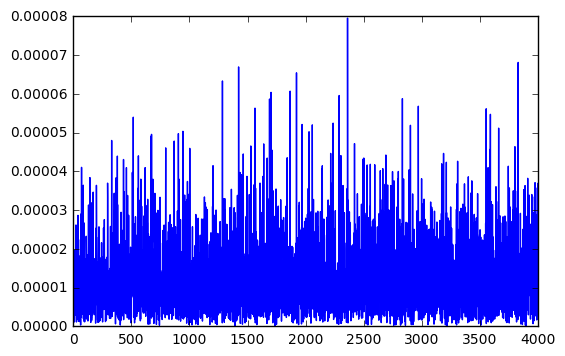

In [316]:
print dfk['pct_mortality'].values[2000], dfk['pop'].values[2000]
theta_0 = samples[:, 2000]
plt.plot(range(len(theta_0)), theta_0)

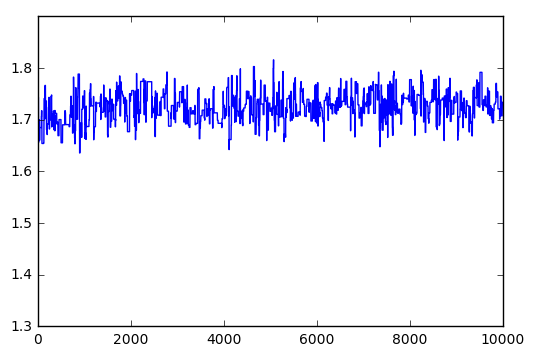

In [317]:
plt.plot(range(len(alpha)), alpha)

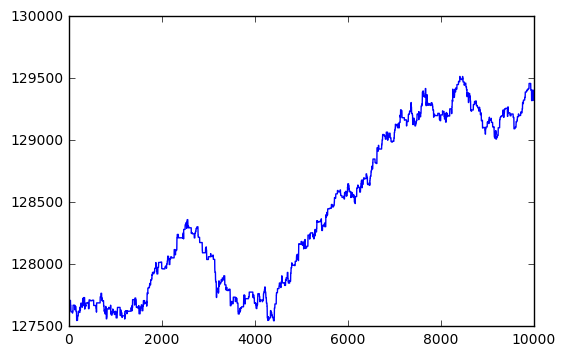

In [318]:
plt.plot(range(len(beta)), beta)

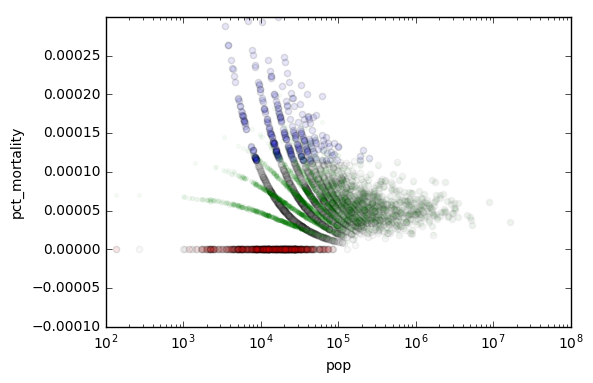

In [305]:
mean_samples = np.array(samples).mean(axis=0)
scatter_plot_cancer_rates(dfk, mean_samples)
plt.show()